In [1]:
import os
import pandas as pd
import seaborn as sns

In [2]:
import re
import json
import os
import argparse

def get_choice(answer_str):
    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'A)', 'B)', 'C)', 'D)', 'E)', 'F)', 'G)', 'H)', 
               'A.', 'B.', 'C.', 'D.', 'E.', 'F.', 'G.', 'H.']
    
    if answer_str is None:
        return ''
    answer_str=answer_str.strip()
    
    for c in choices:
        if answer_str.startswith(c):
            return c.replace(')', '')

    if answer_str.startswith(':'):
       return answer_str.replace(':', '').replace('.', '').strip()
    return ''

def evaluate_QA(QA_results):
    total_em = 0.0
    not_in_options = 0.0
    count = 0
    for sample in QA_results:
        gold_answer = sample['answer'].replace('(', '').replace(')', '').strip()
        answer_str = sample['predicted_answer'].strip() if sample['predicted_answer'] is not None else ''
        prediction = get_choice(answer_str)

        indicators = ['the correct option is', 'the correct answer is', 
                      'The correct answer is', 'The correct option is',
                      'Thus, the answer is']
        if prediction is None:
            for indicator in indicators:
                if answer_str.find(indicator)>=0:
                    answer_str = answer_str.split(indicator)[1].strip()
                    prediction = get_choice(answer_str)
                    break

        if prediction is None:
            not_in_options+=1
            
        em_score = 1.0 if prediction == gold_answer else 0.0
        total_em += em_score
        count += 1
    
    if count!=0:
        avg_em = total_em / count
    else:
        avg_em = 0
    return avg_em

def full_evaluation(result_file):
    with open(result_file, 'r') as f:
        all_samples = json.load(f)

    executable_samples = [sample for sample in all_samples if sample['flag'] == 'success']
    return evaluate_QA(all_samples), len(executable_samples)/len(all_samples), evaluate_QA(executable_samples)

In [3]:
df_main = pd.DataFrame(columns=["model","iteration","split","iteration","exec_rate","exec_accuracy","accuracy"])

# Direct and CoT results

In [4]:
df_all=[]
for file in os.listdir("./outputs/results"):
    if "mini_test" in file:
        continue

    if "Bloke" in file:
        continue

    if "checkpoint" in file:
        continue
    
    mode, dataset, split, model = file.split("_")
    model = model[:-5]
    result_file = os.path.join("./outputs/results",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()

    df=pd.DataFrame(all_samples)
    df["clean_answer"] = df.predicted_answer.apply(get_choice)
    df = df.drop(columns=["question","predicted_reasoning", "predicted_answer"])
    df["answer"] = df.answer.str.replace('(', '').replace(')', '')
    df["is_correct"] = df.answer == df.clean_answer
    df["is_empty"] = df.clean_answer == ''
    df["mode"] = mode
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model
    df["refiment"] = 0
    df_all.append(df)

In [5]:
df_all2=pd.concat(df_all)
df_all3=df_all2.groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

In [6]:
# sns.relplot(data=df_all3,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [7]:
# sns.relplot(data=df_all3,x="model",y="is_empty",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [8]:
df_all4=df_all2.loc[df_all2.is_empty!=True,:].groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

In [9]:
# sns.relplot(data=df_all4,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [10]:
df_logic=[]
for file in os.listdir("./outputs/logic_inference"):
    if "mini_test" in file:
        continue

    if "minitest" in file:
        continue

    if "Bloke" in file:
        continue

    # if "backup-random" in file:
    #     continue

    if "checkpoint" in file:
        continue

    if 'self-refine' in file:
        refine, dataset, split, model, backup = file.split("_")
        refine = int(refine.split('-')[-1])
    else:
        dataset, split, model, backup = file.split("_")
        refine = 0
    
    result_file = os.path.join("./outputs/logic_inference",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()
    df=pd.DataFrame(all_samples)
    if len(df) == 0:
        print(file)
        continue
    df["clean_answer"] = df.predicted_answer.apply(get_choice)
    df = df.drop(columns=["question", "predicted_answer","context"])
    df["answer"] = df.answer.str.replace('(', '').replace(')', '')
    df["is_correct_backup"] = df.answer == df.clean_answer
    df["is_empty"] = df.clean_answer == ''
    df["is_correct"] = (df["is_correct_backup"]) & (df["flag"] == "success")
    df["mode"] = 'Logic'
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model
    df["refiment"] = refine
    df_logic.append(df)

ProofWriter_dev_meta-llama-Llama-2-70b-hf-ProofWriter-sft-full-0-lora-r-16-zero-0-neftune-0-best-beam5-group1-zero-0_backup-random.json


In [11]:
df_programs=[]
for file in os.listdir("./outputs/logic_programs"):
    if "mini_test" in file:
        continue

    if "minitest" in file:
        continue

    if "Bloke" in file:
        continue

    # if "backup-random" in file:
    #     continue

    if "checkpoint" in file:
        continue

    if 'self-refine' in file:
        refine, dataset, split, model = file.split("_")
        refine = int(refine.split('-')[-1])
    else:
        dataset, split, model = file.split("_")
        refine = 0
    
    result_file = os.path.join("./outputs/logic_programs",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()

    df=pd.DataFrame(all_samples)
    if len(df) == 0:
        print(file)
        continue
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model[:-5]
    df["refiment"] = refine
    df_programs.append(df)

In [12]:
df_logic2=pd.concat(df_logic)

df_logic2["n_beam"]=df_logic2.groupby(["id","model","dataset","split","refiment"]).cumcount()

df_logic2 = df_logic2.loc[df_logic2["n_beam"] == 0]

df_total2 = pd.concat([df_all2,df_logic2])

df_total5 = df_total2.loc[(df_total2["mode"] == "Logic"),:]

df_total5["compiled"]=(df_total5["flag"] == "success")
df_total5["size"]=1

/tmp/ipykernel_4026863/3675945497.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total5["compiled"]=(df_total5["flag"] == "success")
/tmp/ipykernel_4026863/3675945497.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total5["size"]=1


In [13]:
results_summary = df_total5.groupby(["model","dataset","mode","split","refiment"])[["is_correct","is_empty","compiled","size"]].sum().reset_index()

In [14]:
results_summary["is_correct_perc"]=100*results_summary["is_correct"]/results_summary["size"]
results_summary["is_empty_perc"]=100*results_summary["is_empty"]/results_summary["size"]
results_summary["compiled_perc"]=100*results_summary["compiled"]/results_summary["size"]
results_summary["is_correct_compiled_perc"]=100*results_summary["is_correct"]/results_summary["compiled"]

In [15]:
def extract_base_model(model_name):
    datasets = ['AR-LSAT', 'ProntoQA', 'ProofWriter', 'FOLIO', 'LogicalDeduction']
    
    for dataset in datasets:
        if dataset in model_name:
            return model_name.split(dataset)[0].strip('-')
    
    return model_name  # Return original if no match found

# Apply the function to create a new column
results_summary['base_model'] = results_summary['model'].apply(extract_base_model)

In [16]:
import pandas as pd
import re

def extract_model_info(model_name):
    info = {}
    
    # Extract full value
    full_match = re.search(r'full-(\d+)', model_name)
    info['full'] = int(full_match.group(1)) if full_match else None
    
    # Extract lora-r value
    lora_r_match = re.search(r'lora-r-(\d+)', model_name)
    info['lora_r'] = int(lora_r_match.group(1)) if lora_r_match else None
    
    # Extract zero value
    zero_match = re.search(r'zero-(\d+)', model_name)
    info['zero'] = int(zero_match.group(1)) if zero_match else None
    
    # Extract neftune value
    neftune_match = re.search(r'neftune-(\d+)', model_name)
    info['neftune'] = int(neftune_match.group(1)) if neftune_match else 0
    
    # Extract beam value
    beam_match = re.search(r'beam(\d+)', model_name)
    info['beam'] = int(beam_match.group(1)) if beam_match else 1
    
    # Extract group value
    group_match = re.search(r'group(\d+)', model_name)
    info['group'] = int(group_match.group(1)) if group_match else 0
    
    # Extract last zero value
    last_zero_match = re.search(r'zero-(\d+)$', model_name)
    info['last_zero'] = int(last_zero_match.group(1)) if last_zero_match else None
    
    return pd.Series(info)

# Create a sample DataFrame
data = {
    'model_name': [
        'meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-0-lora-r-16-zero-1-neftune-0-best-beam5-group1-zero-0',
        'meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-1-lora-r-8-zero-2-neftune-1-best-beam3-group2-zero-1',
        'meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-0-lora-r-32-zero-0-neftune-0-best-beam7-group3-zero-2'
    ]
}

df = pd.DataFrame(data)

# Apply the function to the 'model_name' column and create new columns
df = pd.concat([df, df['model_name'].apply(extract_model_info)], axis=1)

# Display the result
print(df)

                                          model_name  full  lora_r  zero  \
0  meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...     0      16     1   
1  meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...     1       8     2   
2  meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...     0      32     0   

   neftune  beam  group  last_zero  
0        0     5      1          0  
1        1     3      2          1  
2        0     7      3          2  


In [17]:
results_summary = pd.concat([results_summary, results_summary['model'].apply(extract_model_info)], axis=1)

In [18]:
results_summary

,model,dataset,mode,split,refiment,is_correct,is_empty,compiled,size,is_correct_perc,...,compiled_perc,is_correct_compiled_perc,base_model,full,lora_r,zero,neftune,beam,group,last_zero
0,gpt-3.5-turbo,AR-LSAT,Logic,dev,0,14,0,44,231,6.060606,...,19.047619,31.818182,gpt-3.5-turbo,NaN,NaN,NaN,0.0,1.0,0.0,NaN
1,gpt-3.5-turbo,FOLIO,Logic,dev,0,80,0,125,204,39.215686,...,61.274510,64.000000,gpt-3.5-turbo,NaN,NaN,NaN,0.0,1.0,0.0,NaN
2,gpt-3.5-turbo,LogicalDeduction,Logic,dev,0,194,59,293,300,64.666667,...,97.666667,66.211604,gpt-3.5-turbo,NaN,NaN,NaN,0.0,1.0,0.0,NaN
3,gpt-3.5-turbo,ProntoQA,Logic,dev,0,272,0,455,500,54.400000,...,91.000000,59.780220,gpt-3.5-turbo,NaN,NaN,NaN,0.0,1.0,0.0,NaN
4,gpt-3.5-turbo,ProofWriter,Logic,dev,0,228,0,336,600,38.000000,...,56.000000,67.857143,gpt-3.5-turbo,NaN,NaN,NaN,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,mistralai-Mixtral-8x7B-v0.1-AR-LSAT-sft-lora-r...,AR-LSAT,Logic,dev,0,9,0,30,231,3.896104,...,12.987013,30.000000,mistralai-Mixtral-8x7B-v0.1,NaN,32.0,0.0,5.0,1.0,0.0,0.0
333,mistralai-Mixtral-8x7B-v0.1-FOLIO-sft-lora-r-3...,FOLIO,Logic,dev,0,96,0,160,204,47.058824,...,78.431373,60.000000,mistralai-Mixtral-8x7B-v0.1,NaN,32.0,0.0,5.0,1.0,0.0,0.0
334,mistralai-Mixtral-8x7B-v0.1-LogicalDeduction-s...,LogicalDeduction,Logic,dev,0,230,32,300,300,76.666667,...,100.000000,76.666667,mistralai-Mixtral-8x7B-v0.1,NaN,32.0,0.0,5.0,1.0,0.0,0.0
335,mistralai-Mixtral-8x7B-v0.1-ProntoQA-sft-lora-...,ProntoQA,Logic,dev,0,497,0,497,500,99.400000,...,99.400000,100.000000,mistralai-Mixtral-8x7B-v0.1,NaN,32.0,0.0,5.0,1.0,0.0,0.0


In [19]:
results_summary['is_tuned'] = results_summary['model'].str.contains('sft')

In [20]:
results_summary["is_correct_compiled_perc"] = results_summary.is_correct_compiled_perc.fillna(0)
results_summary["mode"] = results_summary["mode"].fillna("Logic")

In [21]:
# sns.relplot(data=results_summary.loc[(results_filtered.last_zero==0) & (results_summary.dataset=="ProofWriter") & (results_summary.split=="dev") & (results_summary.is_tuned==True)],x="compiled_perc",y="is_correct_perc",col="beam",row="lora_r").tick_params(axis='x', rotation=45)

In [22]:
results_filtered = results_summary.loc[(results_summary.full.isna()) & (results_summary.group==0) & (results_summary.beam==1) & (results_summary.base_model=='meta-llama-Llama-2-7b-hf') & (results_summary.split=="dev") & (results_summary.is_tuned==True)]

In [23]:
results_filtered.columns

Index(['model', 'dataset', 'mode', 'split', 'refiment', 'is_correct',
       'is_empty', 'compiled', 'size', 'is_correct_perc', 'is_empty_perc',
       'compiled_perc', 'is_correct_compiled_perc', 'base_model', 'full',
       'lora_r', 'zero', 'neftune', 'beam', 'group', 'last_zero', 'is_tuned'],
      dtype='object')

In [24]:
results_filtered["NEFTune"] = results_filtered["neftune"].astype(int)
results_filtered["LoRA R"] = results_filtered["lora_r"].astype(int)
results_filtered["zero"] = results_filtered["zero"].astype(bool)
results_filtered["last_zero"] = results_filtered["last_zero"].astype(bool)
results_filtered["generation"] = "Zero-shot Training: "+results_filtered["zero"].astype(str) + " Zero-shot Generation: "+results_filtered["last_zero"].astype(str)

/tmp/ipykernel_4026863/4206091987.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_filtered["NEFTune"] = results_filtered["neftune"].astype(int)
/tmp/ipykernel_4026863/4206091987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_filtered["LoRA R"] = results_filtered["lora_r"].astype(int)
/tmp/ipykernel_4026863/4206091987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

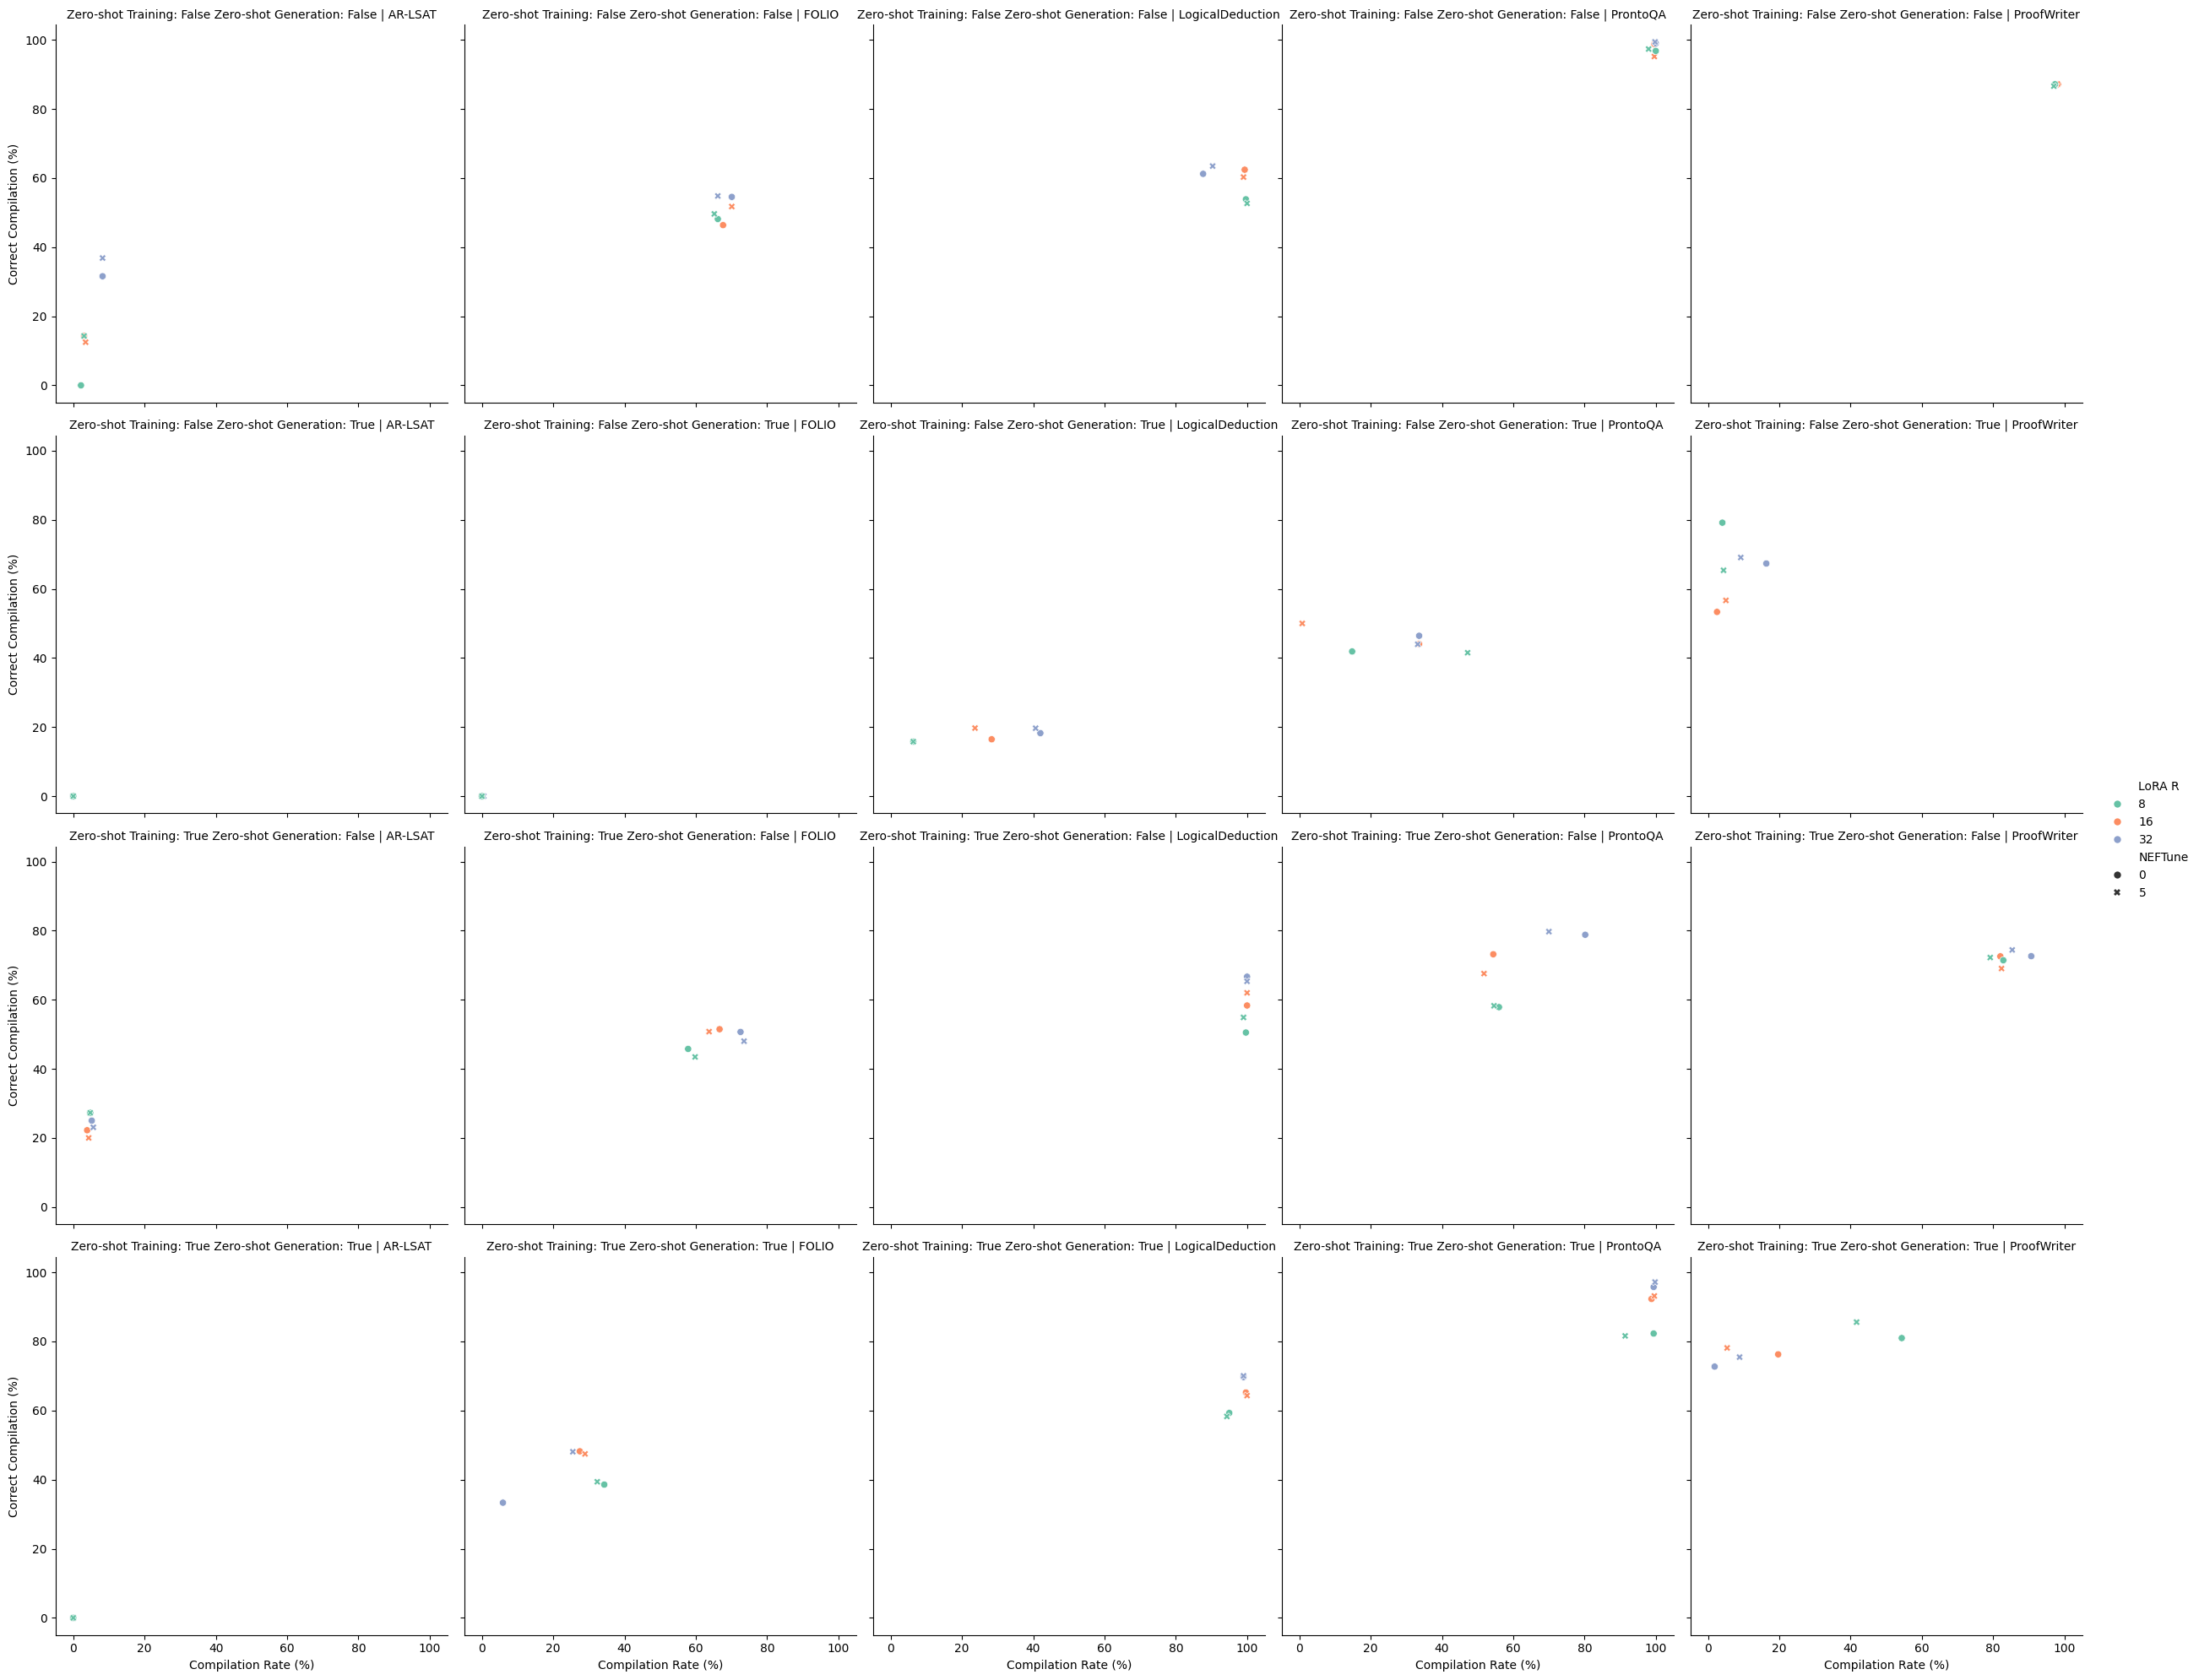

In [25]:
(sns.relplot(data=results_filtered, 
            x="compiled_perc", 
            y="is_correct_compiled_perc",
            col="dataset",
            row="generation",
            hue="LoRA R",
            style="NEFTune",palette="Set2")
    .set_titles(col_template="{col_name}", row_template="{row_name}")  # Better labels
    .set(xlabel="Compilation Rate (%)", 
         ylabel="Correct Compilation (%)")
)

In [87]:
results_summary_final = results_summary.loc[(((results_summary.neftune==5) & (results_summary.last_zero==0) & 
(results_summary.zero==0) & (results_summary.lora_r==32) & (results_summary.is_tuned==True))
 | (results_summary.is_tuned==False)) & (results_summary.split=="dev") & (results_summary.beam==1) & (results_summary.refiment==0)]

In [88]:
results_summary.base_model.unique()

array(['gpt-3.5-turbo', 'gpt-4', 'meta-llama-Llama-2-13b-hf',
       'meta-llama-Llama-2-70b-hf', 'meta-llama-Llama-2-7b-hf',
       'mistralai-Mistral-7B-v0.1', 'mistralai-Mixtral-8x7B-v0.1'],
      dtype=object)

In [89]:
results_summary_final.base_model=results_summary_final.base_model.str.replace("meta-llama-","")
results_summary_final.base_model=results_summary_final.base_model.str.replace("mistralai-","")
results_summary_final.base_model=results_summary_final.base_model.str.replace("-turbo","-davinci")

/tmp/ipykernel_4026863/3817560988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_summary_final.base_model=results_summary_final.base_model.str.replace("meta-llama-","")
/tmp/ipykernel_4026863/3817560988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_summary_final.base_model=results_summary_final.base_model.str.replace("mistralai-","")
/tmp/ipykernel_4026863/3817560988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [90]:
# Values taken from paper report because of usage of CoT results as backup and problems with PyKe solver
results_summary_final.loc[results_summary_final.base_model=="gpt-4","is_correct_perc"]=np.array([43.04,78.92,87.63,83.20,79.66])
results_summary_final.loc[results_summary_final.base_model=="gpt-3.5-davinci","is_correct_perc"]=np.array([25.54,61.27,62.00,85.00,71.45])

In [101]:
results_summary_final.columns

Index(['model', 'dataset', 'mode', 'split', 'refiment', 'is_correct',
       'is_empty', 'compiled', 'size', 'is_correct_perc', 'is_empty_perc',
       'compiled_perc', 'is_correct_compiled_perc', 'base_model', 'full',
       'lora_r', 'zero', 'neftune', 'beam', 'group', 'last_zero', 'is_tuned'],
      dtype='object')

In [102]:
results_summary_final.loc[results_summary_final.base_model=="Llama-2-70b-hf",["dataset","base_model","is_correct_perc","compiled_perc","is_correct_compiled_perc"]]

,dataset,base_model,is_correct_perc,compiled_perc,is_correct_compiled_perc
45,AR-LSAT,Llama-2-70b-hf,3.030303,15.584416,19.444444
50,FOLIO,Llama-2-70b-hf,27.450980,48.529412,56.565657
55,LogicalDeduction,Llama-2-70b-hf,44.666667,100.000000,44.666667
60,ProntoQA,Llama-2-70b-hf,70.600000,98.800000,71.457490
65,ProofWriter,Llama-2-70b-hf,52.166667,74.000000,70.495495
70,AR-LSAT,Llama-2-70b-hf,2.164502,15.151515,14.285714
71,FOLIO,Llama-2-70b-hf,47.549020,83.333333,57.058824
72,LogicalDeduction,Llama-2-70b-hf,77.333333,100.000000,77.333333
73,ProntoQA,Llama-2-70b-hf,98.800000,99.800000,98.997996
76,ProofWriter,Llama-2-70b-hf,92.333333,99.333333,92.953020


In [94]:
results_summary_final.base_model.unique()

array(['gpt-3.5-davinci', 'gpt-4', 'Llama-2-13b-hf', 'Llama-2-70b-hf',
       'Llama-2-7b-hf', 'Mistral-7B-v0.1', 'Mixtral-8x7B-v0.1'],
      dtype=object)

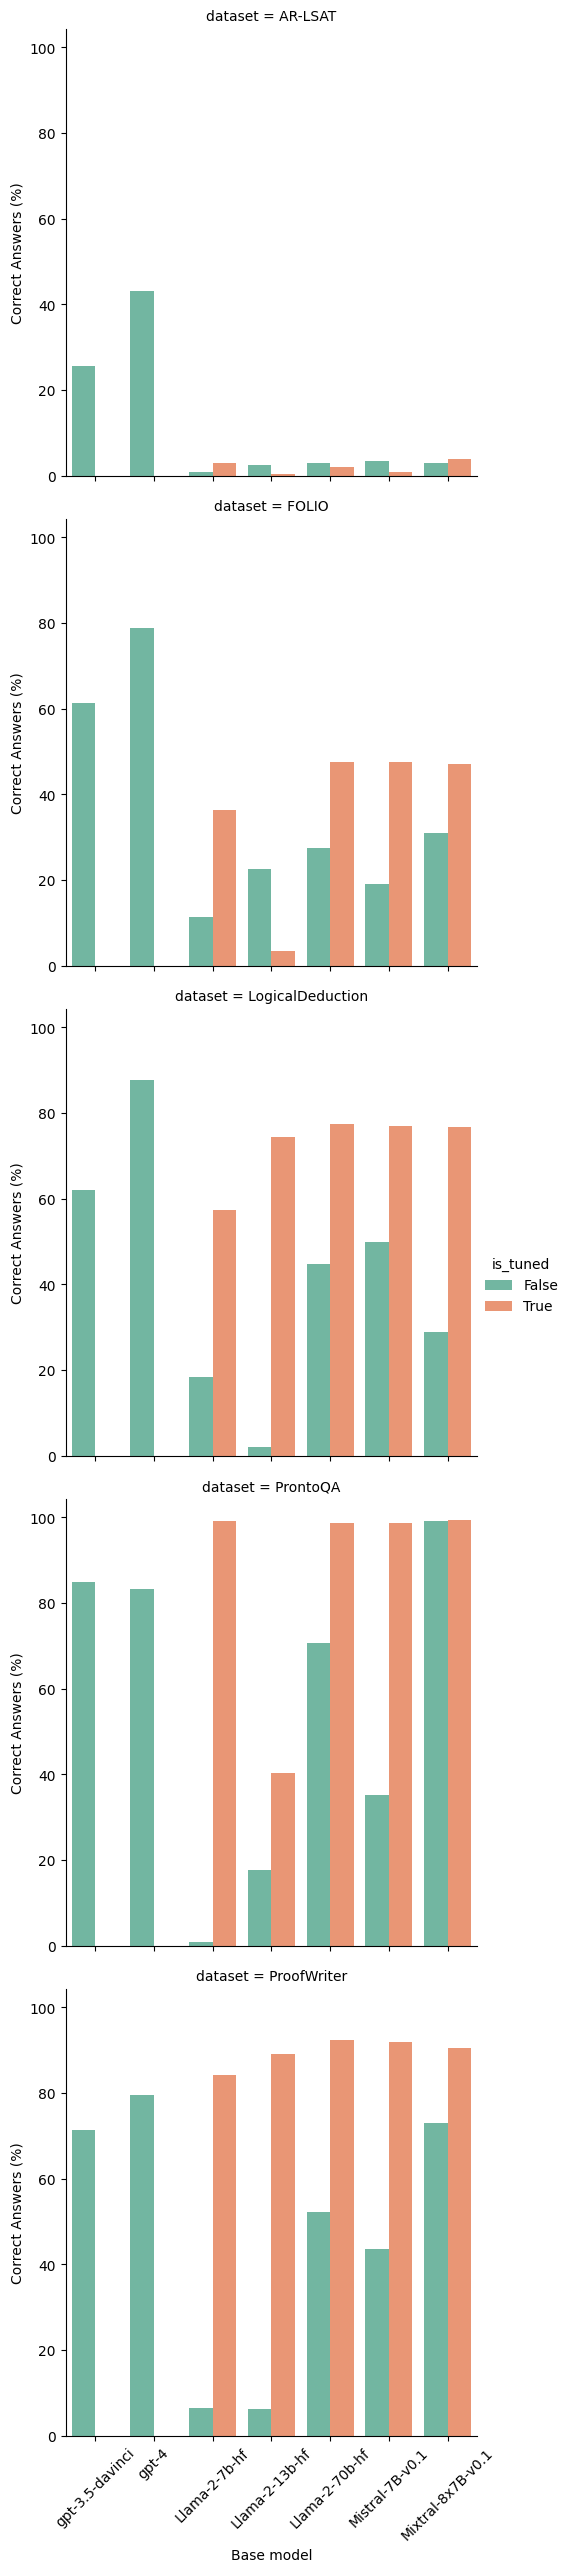

In [96]:
sns.catplot(data=results_summary_final, x="base_model", y="is_correct_perc", kind="bar",hue="is_tuned",row="dataset",order=['gpt-3.5-davinci', 'gpt-4','Llama-2-7b-hf', 'Llama-2-13b-hf', 'Llama-2-70b-hf',
       'Mistral-7B-v0.1', 'Mixtral-8x7B-v0.1'] ,palette="Set2").set(xlabel="Base model",ylabel="Correct Answers (%)").tick_params(axis='x', rotation=45)

In [29]:
LSAT_train=pd.read_csv('outputs/prepared_data/AR-LSAT_train_merged_data_sft_2024-12-06.csv')
print(LSAT_train.shape)
print(LSAT_train.prompt.unique().shape)

(123, 2)
(101,)


In [30]:
FOLIO_train=pd.read_csv('outputs/prepared_data/FOLIO_train_merged_data_sft_2024-12-06.csv')
print(FOLIO_train.shape)
print(FOLIO_train.prompt.unique().shape)

(1101, 2)
(552,)


In [31]:
ProntoQA_train=pd.read_csv('outputs/prepared_data/ProntoQA_train_merged_data_sft_2024-12-06.csv')
print(ProntoQA_train.shape)
print(ProntoQA_train.prompt.unique().shape)

(1969, 2)
(1202,)


In [32]:
ProofWriter_train=pd.read_csv('outputs/prepared_data/ProofWriter_train_merged_data_sft_2024-11-13.csv')
print(ProofWriter_train.shape)
print(ProofWriter_train.prompt.unique().shape)

(2236, 2)
(1514,)


In [33]:
LogicalDeduction_train=pd.read_csv('outputs/prepared_data/LogicalDeduction_train_merged_data_sft_2024-11-13.csv')
print(LogicalDeduction_train.shape)
print(LogicalDeduction_train.prompt.unique().shape)

(1682, 2)
(826,)


In [34]:
# Pivot the DataFrame
friedman_df = results_filtered.pivot(
    index='dataset',  # Rows will be datasets
    columns=['lora_r', 'zero', 'neftune', 'last_zero'],  # Combine hyperparameters for columns
    values='is_correct_perc'  # The values will be accuracies
)

# If you need to reset the index
# friedman_df = friedman_df.reset_index()

In [35]:
friedman_df

lora_r                 16.0                                             \
zero                  False                                      True    
neftune                 0.0                   5.0                  0.0   
last_zero             False      True       False     True       False   
dataset                                                                  
AR-LSAT            0.432900   0.000000   0.432900  0.000000   0.865801   
FOLIO             31.372549   0.000000  36.274510  0.000000  34.313725   
LogicalDeduction  62.000000   4.666667  59.666667  4.666667  58.333333   
ProntoQA          98.400000  14.800000  94.800000  0.400000  39.800000   
ProofWriter       85.500000   1.333333  85.500000  2.833333  59.500000   

lora_r                                                  32.0             ...  \
zero                                                   False             ...   
neftune                            5.0                   0.0             ...   
last_zero             True       False      True       False      True   ...   
dataset                                                                  ...   
AR-LSAT            0.000000   0.865801   0.000000   2.597403   0.000000  ...   
FOLIO             13.235294  32.352941  13.725490  38.235294   0.000000  ...   
LogicalDeduction  65.000000  62.000000  64.333333  53.666667   7.666667  ...   
ProntoQA          91.200000  35.000000  92.800000  99.000000  15.600000  ...   
ProofWriter       15.000000  56.833333   4.166667  84.666667  11.000000  ...   

lora_r                                       8.0                        \
zero                  True                  False                        
neftune                 5.0                   0.0                  5.0   
last_zero             False      True       False     True       False   
dataset                                                                  
AR-LSAT            1.298701   0.000000   0.000000  0.000000   0.432900   
FOLIO             35.294118  12.254902  31.862745  0.000000  32.352941   
LogicalDeduction  65.333333  69.333333  53.666667  1.000000  52.666667   
ProntoQA          55.800000  97.000000  96.800000  6.200000  95.400000   
ProofWriter       63.500000   6.666667  84.833333  3.166667  84.000000   

lora_r                                                                   
zero                             True                                    
neftune                            0.0                   5.0             
last_zero             True       False      True       False      True   
dataset                                                                  
AR-LSAT            0.000000   1.298701   0.000000   1.298701   0.000000  
FOLIO              0.000000  26.470588  13.235294  25.980392  12.745098  
LogicalDeduction   1.000000  50.333333  56.333333  54.333333  55.000000  
ProntoQA          19.600000  32.400000  81.800000  31.800000  74.600000  
ProofWriter        2.833333  59.166667  44.000000  57.166667  35.666667  

[5 rows x 24 columns]

In [36]:
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# Assume 'data' is a numpy array of shape (datasets, hyperparameter_sets)
data = np.array(
    friedman_df
)

# Perform Friedman test
from scipy.stats import friedmanchisquare
stat, p = friedmanchisquare(*[data[:, i] for i in range(data.shape[1])])
print(f'Friedman test statistic: {stat}, p-value: {p}')

# If significant, proceed with Nemenyi test
if p < 0.05:
    print('Significant differences found. Performing Nemenyi post-hoc test...')
    p_values = sp.posthoc_nemenyi_friedman(data)

    # Calculate average ranks
    from scipy.stats import rankdata
    ranks = [rankdata(-row) for row in data]
    avg_ranks = np.mean(ranks, axis=0)

    # Identify the best hyperparameter set(s)
    best_index = np.argmin(avg_ranks)
    print(f'Best hyperparameter set is Set {best_index+1} with average rank {avg_ranks[best_index]}')

    # Examine p-values for the best set
    best_set_p_values = p_values.iloc[best_index]
    print(f'P-values comparing the best set to others:\n{best_set_p_values}')

    # Identify sets not significantly different from the best set
    not_significant = best_set_p_values[best_set_p_values >= 0.05].index
    print(f'Sets not significantly different from the best set: {not_significant}')
else:
    print('No significant differences found among hyperparameter sets.')

Friedman test statistic: 72.87694113398338, p-value: 4.338420281127744e-07
Significant differences found. Performing Nemenyi post-hoc test...
Best hyperparameter set is Set 11 with average rank 4.3
P-values comparing the best set to others:
0     1.000000
1     0.033243
2     1.000000
3     0.028368
4     0.999980
5     0.979725
6     0.999864
7     0.960435
8     1.000000
9     0.136224
10    1.000000
11    0.092402
12    1.000000
13    0.913888
14    1.000000
15    0.996884
16    0.999864
17    0.030720
18    0.999990
19    0.045233
20    0.989007
21    0.913888
22    0.992131
23    0.813728
Name: 10, dtype: float64
Sets not significantly different from the best set: Index([0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23], dtype='object')


In [37]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


In [38]:
path="/mnt/evafs/groups/luckner-lab/models/mistralai/Mistral-7B-v0.1/LogicalDeduction/sft/runs/Jun11_22-53-05_dgx-4.eden" #folderpath
df=tflog2pandas(path)

In [39]:
df.metric.unique()

array(['train/loss', 'train/grad_norm', 'train/learning_rate',
       'train/epoch', 'eval/loss', 'eval/runtime',
       'eval/samples_per_second', 'eval/steps_per_second',
       'train/train_runtime', 'train/train_samples_per_second',
       'train/train_steps_per_second', 'train/total_flos',
       'train/train_loss'], dtype=object)

In [40]:
df

,metric,value,step
0,train/loss,3.482000e-01,10.0
1,train/loss,9.910000e-02,20.0
2,train/loss,5.540000e-02,30.0
3,train/loss,4.700000e-02,40.0
4,train/loss,4.270000e-02,50.0
...,...,...,...
0,train/train_runtime,7.297424e+02,396.0
0,train/train_samples_per_second,2.168000e+00,396.0
0,train/train_steps_per_second,5.430000e-01,396.0
0,train/total_flos,1.106620e+17,396.0


In [41]:
# sns.lineplot(data=df.loc[df.metric=="eval/loss",:],x="step",y="value").set(ylabel="Train Loss", title="LogicalDeduction")

[Text(0, 0.5, 'Train Loss'), Text(0.5, 1.0, 'LogicalDeduction')]

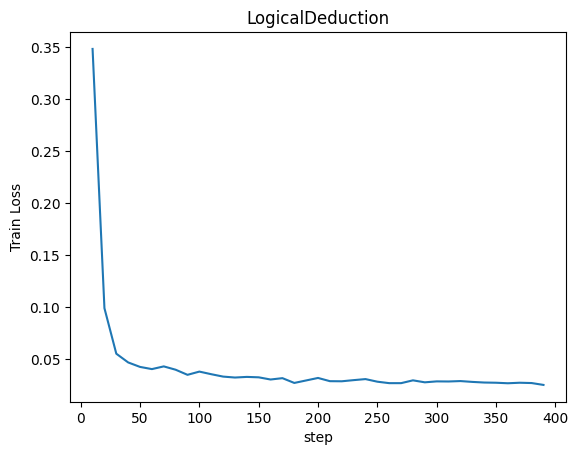

In [42]:
sns.lineplot(data=df.loc[df.metric=="train/loss",:],x="step",y="value").set(ylabel="Train Loss", title="LogicalDeduction")